In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:

from IPython.display import Markdown, display

def print_classification_report_md(y_true, y_pred):
    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    # Build Markdown string for the table
    markdown_str = "| Class | Precision | Recall | F1 Score | Support |\n| --- | --- | --- | --- | --- |\n"
    for key, value in report.items():
        if key == 'accuracy':
            # Skip the accuracy since it's not part of the per-class report
            continue
        if isinstance(value, dict):  # Check if the value is a metrics dictionary
            markdown_str += f"| {key} | {value['precision']:.2f} | {value['recall']:.2f} | {value['f1-score']:.2f} | {value['support']} |\n"

    # Print the overall accuracy as well
    overall_accuracy = report.get('accuracy', None)
    if overall_accuracy is not None:
        markdown_str += f"| **Overall** | | | **Accuracy** | {overall_accuracy:.2f} |\n"

    # Display using Markdown
    display(Markdown(markdown_str))

In [15]:
train_set_url_20_balanced = "data/KDDTrain_20%_balanced.csv"
test_set_url_20 = "data/KDDTest_for20%_processed.csv"

df_train = pd.read_csv(train_set_url_20_balanced)
df_test = pd.read_csv(test_set_url_20)

# Split the dataset into features and target
X = df_train.drop('attack_class', axis=1)
y = df_train['attack_class']

X_test = df_test.drop('attack_class', axis=1)
y_test = df_test['attack_class']

In [16]:
# Convert the Series to a numpy array and then reshape it to be 2D
y = y.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the training labels
y_encoded = encoder.fit_transform(y)

# Transform the test labels
y_test_encoded = encoder.transform(y_test)

In [17]:
# Define the neural network architecture
model = Sequential([
    Dense(128, input_shape=(X.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_encoded.shape[1], activation='softmax')
])

In [18]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# summary of model_nn layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               15104     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 23685 (92.52 KB)
Trainable params: 23685 (92.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train the model
history = model.fit(X, y_encoded, validation_data=(X_test, y_test_encoded), epochs=100, batch_size=32)

Epoch 1/100
2094/2094 [==============================] - 5s 2ms/step - loss: 0.0792 - accuracy: 0.9762 - val_loss: 1.6049 - val_accuracy: 0.7952
Epoch 2/100
2094/2094 [==============================] - 4s 2ms/step - loss: 0.0227 - accuracy: 0.9933 - val_loss: 2.2346 - val_accuracy: 0.7826
Epoch 3/100
2094/2094 [==============================] - 4s 2ms/step - loss: 0.0154 - accuracy: 0.9954 - val_loss: 2.8532 - val_accuracy: 0.7703
Epoch 4/100
2094/2094 [==============================] - 4s 2ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 3.0312 - val_accuracy: 0.7675
Epoch 5/100
2094/2094 [==============================] - 4s 2ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 3.3378 - val_accuracy: 0.7850
Epoch 6/100
2094/2094 [==============================] - 4s 2ms/step - loss: 0.0107 - accuracy: 0.9977 - val_loss: 3.6918 - val_accuracy: 0.7728
Epoch 7/100
2094/2094 [==============================] - 4s 2ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 4.1377 - val_ac

In [22]:
# Evaluate the model_nn
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f'TEST RESULTS: Loss: {loss}, Accuracy: {accuracy}')

705/705 [==============================] - 1s 1ms/step - loss: 21.6664 - accuracy: 0.7513
TEST RESULTS: Loss: 21.666353225708008, Accuracy: 0.7513307332992554


In [23]:
y_pred = model.predict(X_test)

705/705 [==============================] - 1s 1ms/step


| Class | Precision | Recall | F1 Score | Support |
| --- | --- | --- | --- | --- |
| 0 | 0.91 | 0.83 | 0.87 | 7458.0 |
| 1 | 0.67 | 0.93 | 0.78 | 9711.0 |
| 2 | 0.73 | 0.64 | 0.68 | 2421.0 |
| 3 | 0.81 | 0.05 | 0.10 | 2754.0 |
| 4 | 0.62 | 0.12 | 0.19 | 200.0 |
| macro avg | 0.75 | 0.51 | 0.52 | 22544.0 |
| weighted avg | 0.77 | 0.75 | 0.71 | 22544.0 |
| **Overall** | | | **Accuracy** | 0.75 |


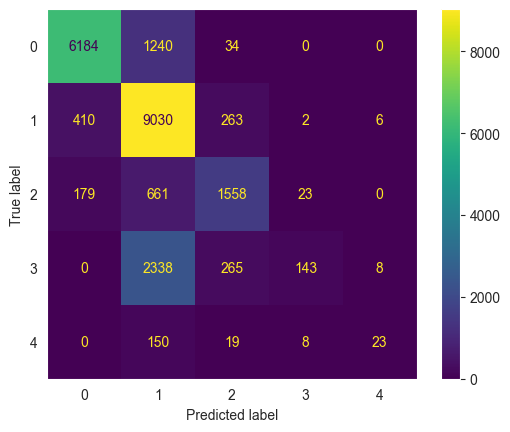

In [29]:
# Convert predictions from one-hot encoded vectors to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
# Convert one-hot encoded test labels back to class labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Calculate metrics
print_classification_report_md(y_test_classes, y_pred_classes)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_classes, y_pred_classes))
disp.plot()
plt.grid(False)
plt.show()

In [31]:
# Save the model_nn and the scaler
model.save('nn_model.keras')